In [17]:
import warnings
warnings.filterwarnings('ignore')
import os

In [18]:
__file__ = 'InceptionResNetV2-Xception-8.30.3-0'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [19]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras_applications.resnext import ResNeXt50
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
import PIL
import time

def preprocess_img(x):
    x = x / 127.5
    x -= 1.
    return x

In [20]:
path_data = '../garbage_classify/train_data'
batch_size = 16
img_size = 299
img_width = img_size
img_height = img_size
random_seed = 201908
path_data_train = '../tmp/data_train/'
path_data_valid = '../tmp/data_valid/'
labels_file = '../tmp/labels_raw.csv'

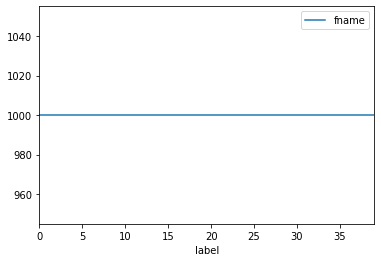

In [21]:
labels_train = pd.read_csv('../tmp/labels_train.csv')
labels_valid = pd.read_csv('../tmp/labels_valid.csv')
n_classess = labels_train.label.unique().shape[0]
labels_train.groupby(by='label').count().plot()

In [22]:
labels_train.label = labels_train.label.apply(lambda x: f'{x:02d}')
labels_valid.label = labels_valid.label.apply(lambda x: f'{x:02d}')
# labels_train['label_bin'].values = keras.utils.np_utils.to_categorical(
#     labels_train.label, n_classess)

In [23]:
ig = ImageDataGenerator(preprocessing_function=preprocess_img)

params_g = dict(
    batch_size=batch_size,
    # directory=path_data,
    # class_mode='other',
    x_col='fname',
    y_col='label',
    target_size=(img_width, img_height),
    interpolation='lanczos',
    seed=random_seed)

train_g = ig.flow_from_dataframe(
    labels_train, path_data_train, **params_g)
valid_g = ig.flow_from_dataframe(
    labels_valid, path_data_valid, **params_g)

Found 40000 validated image filenames belonging to 40 classes.
Found 2978 validated image filenames belonging to 40 classes.


In [24]:
input_tensor = Input((img_width, img_height, 3))

In [25]:
base_model_InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=True, input_tensor=input_tensor)
base_model_Xception = Xception(weights='imagenet', include_top=True, input_tensor=input_tensor)

91889664/91884032 [==============================] - 18s 0us/step


In [26]:
for layer in base_model_InceptionResNetV2.layers:
    layer.name = 'InceptionResNetV2_'+layer.name
for layer in base_model_Xception.layers:
    layer.name = 'Xception_'+layer.name

In [27]:
a = base_model_InceptionResNetV2.output
b = base_model_Xception.output

# a = GlobalAveragePooling2D()(a)
# b = GlobalAveragePooling2D()(b)

x = Concatenate(axis=-1)([a,b])

In [28]:
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

predictions = Dense(n_classess, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=predictions)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Xception_InceptionResNetV2_inpu (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
InceptionResNetV2_conv2d_208 (C (None, 149, 149, 32) 864         Xception_InceptionResNetV2_input_
__________________________________________________________________________________________________
InceptionResNetV2_batch_normali (None, 149, 149, 32) 96          InceptionResNetV2_conv2d_208[0][0
__________________________________________________________________________________________________
InceptionResNetV2_activation_20 (None, 149, 149, 32) 0           InceptionResNetV2_batch_norm

InceptionResNetV2_block8_1_ac ( (None, 8, 8, 2080)   0           InceptionResNetV2_block8_1[0][0] 
__________________________________________________________________________________________________
Xception_block1_conv2 (Conv2D)  (None, 147, 147, 64) 18432       Xception_block1_conv1_act[0][0]  
__________________________________________________________________________________________________
InceptionResNetV2_conv2d_376 (C (None, 8, 8, 192)    399360      InceptionResNetV2_block8_1_ac[0][
__________________________________________________________________________________________________
Xception_block1_conv2_bn (Batch (None, 147, 147, 64) 256         Xception_block1_conv2[0][0]      
__________________________________________________________________________________________________
InceptionResNetV2_batch_normali (None, 8, 8, 192)    576         InceptionResNetV2_conv2d_376[0][0
__________________________________________________________________________________________________
Xception_b

In [29]:
with open(f'../tmp/model_{__file__}.json','w') as f:
    model_json = model.to_json()
    f.write(model_json)

In [30]:
ckpt = ModelCheckpoint('../tmp/ckpt-'+__file__+'-Epoch_{epoch:03d}-acc_{acc:.5f}-val_acc_{val_acc:.5f}.h5', save_best_only=True, monitor='val_acc')

estop = EarlyStopping(monitor='val_acc', min_delta=1e-7,verbose=1, patience=20)

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(
    train_g,
    # steps_per_epoch=100,
    steps_per_epoch=train_g.n // batch_size,
    epochs=100,
    callbacks=[ckpt, estop],
    validation_data=valid_g,
    # validation_steps=1,
    validation_steps=valid_g.n // batch_size
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
2500/2500 [==============================] - 2005s 802ms/step - loss: 3.6316 - acc: 0.2463 - val_loss: 3.5630 - val_acc: 0.5239
Epoch 2/100
2500/2500 [==============================] - 1958s 783ms/step - loss: 3.4843 - acc: 0.5552 - val_loss: 3.3966 - val_acc: 0.6236
Epoch 3/100
2500/2500 [==============================] - 1968s 787ms/step - loss: 3.2836 - acc: 0.6655 - val_loss: 3.1732 - val_acc: 0.6810
Epoch 4/100
2500/2500 [==============================] - 1966s 786ms/step - loss: 3.0323 - acc: 0.7226 - val_loss: 2.9105 - val_acc: 0.7242
Epoch 5/100
2500/2500 [==============================] - 1960s 784ms/step - loss: 2.7365 - acc: 0.7622 - val_loss: 2.6204 - val_acc: 0.7370
Epoch 6/100
2500/2500 [==============================] - 1965s 786ms/step - loss: 2.4062 - acc: 0.7909 - val_loss: 2.2944 - val_acc: 0.7495
Epoch 7/100
2499/2500 [============================>.] - ETA: 0s - loss: 2.0607 - acc: 0.8122

In [ ]:
batch_size